## Проектная практика «Мониторинг экосистемы через IT-решения»
Интеллектуальная система визуальной детекции лесных пожаров «**FireDetection**»

**Установка зависимостей** (если ранее не установлены)

In [1]:
#!pip install supervision opencv-python pillow matplotlib
#!pip install inference-sdk

**Импорт библиотек**

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import supervision as sv
from inference_sdk import InferenceHTTPClient

**Входные данные (изображение для анализа)**

In [3]:
# В учебном варианте используем одну картинку по URL.
# При необходимости URL можно заменить на локальный файл (тогда вместо requests нужно читать файл).
# В случае дальнейшей разработки можно оптимизировать для работы с потоковыми данными.
fire_image_url = (
    "https://st2.depositphotos.com/4122877/6965/i/450/depositphotos_69657281-stock-photo-forest-fire-in-progress.jpg"
)

**Подключение к Roboflow Inference**

In [4]:
# Создаём клиент для обращения к Roboflow Serverless API:
# api_url — адрес сервиса инференса
# api_key — ключ доступа к вашему workspace / workflow
rf_client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="8e2cBHHaYYQAhRSZaVFc"
)

**Запуск детекции через workflow**

In [5]:
# workflow возвращает список результатов по числу отправленных изображений.
# Здесь отправляем одно изображение, поэтому далее используем элемент [0].
workflow_result = rf_client.run_workflow(
    workspace_name="maksim-korobejnikov-s-workspace",
    workflow_id="find-fires",
    images={"image": fire_image_url},
    use_cache=False
)

**Загрузка изображения для визуализации**

In [6]:
# Roboflow возвращает предсказания, но для вывода картинки необходим объект для обработки - скачиваем изображение.
image_response = requests.get(fire_image_url)

# Приводим к RGB, чтобы гарантировать стандартный формат (3 канала).
fire_image = Image.open(BytesIO(image_response.content)).convert("RGB")

# Переводим в numpy-массив, с ним работают инструменты аннотации.
fire_image_np = np.array(fire_image)

**Преобразование ответа модели в формат supervision**

In [7]:
# Извлекаем результат для одного изображения.
# API возвращает результат в виде словаря для каждого объекта.
# В нашем случае объект всего один => [0]
prediction_payload = workflow_result[0]

# Преобразуем "сырой" ответ (JSON) в структуру Detections (sv.Detections.from_inference):
# - координаты рамок (bbox)
# - class_name
# - confidence
fire_detections = sv.Detections.from_inference(prediction_payload["predictions"])

**Подготовка визуализации предсказания**

In [8]:
# Формируем рамки вокруг найденных областей огня и добавляем подписи с процентом уверенностью модели.
box_drawer = sv.BoxAnnotator()
label_drawer = sv.LabelAnnotator()

labels = [
    f"fire {confidence:.2f}"
    for confidence in fire_detections.confidence
]

# Отрисовываем объекты на копии, чтобы исходный массив можно было использовать отдельно при необходимости.
annotated_fire_image = box_drawer.annotate(
    scene=fire_image_np.copy(),
    detections=fire_detections
)

annotated_fire_image = label_drawer.annotate(
    scene=annotated_fire_image,
    detections=fire_detections,
    labels=labels
)

**Формирование комментария к предсказанию**

In [9]:
fire_count = len(fire_detections)

if fire_count > 0:
    output_message = f"ВНИМАНИЕ! Обнаружены очаги огня. Количество: {fire_count}."
else:
    output_message = "Очагов огня на снимке не обнаружено."

**Вывод результатов**

Результат: ВНИМАНИЕ! Обнаружены очаги огня. Количество: 8.


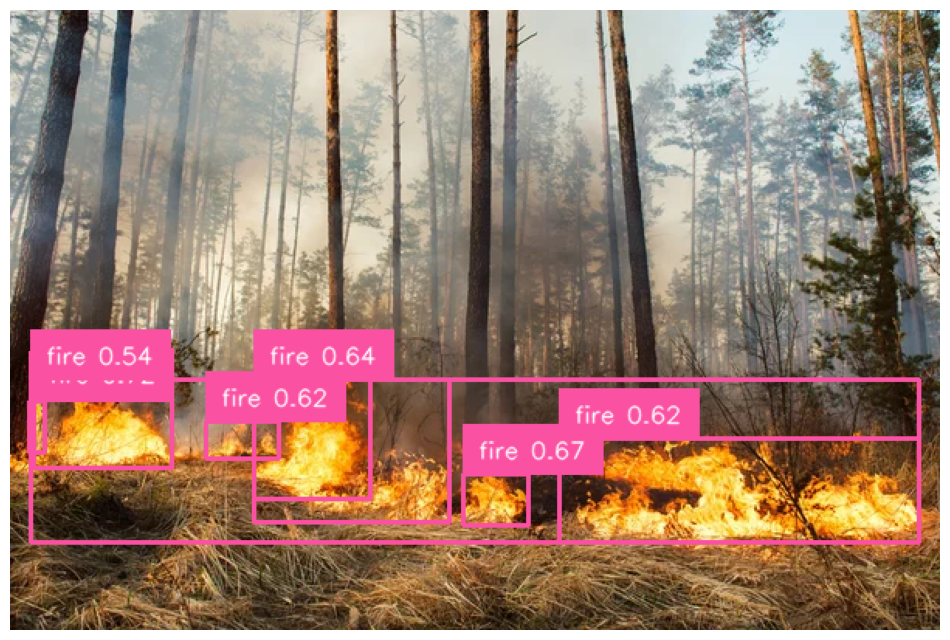

In [10]:
plt.figure(figsize=(12, 12))
plt.imshow(annotated_fire_image)
plt.axis("off")
print("Результат:", output_message)
plt.show()